# Projeto Petrobrás Saúde - Hacking Rio
### Por Equipe 124: Daniel N. Rocha, Everton Arruda e Letícia Florito
Por meio deste projeto, desenvolvemos um algoritmo de machine learning para analisar as cores de um prato de comida e ranqueá-las de acordo com as suas tonalidade. As imagens seriam fornecidas pelos próprio funcionários, que tirariam fotos em seus celulares e enviariam para um aplicativo criado para esse fim. 

Pratos com mais predominância de verde (cor de muitas verduras e legumes) são atrelados a pratos mais saudáveis, enquanto que os que possuem tons amarelos como majoritários (cores de carboidratos) são compreendidos como mais calóricos. 

A ideia do projeto é usar esse ranking como uma gameficação entre os departamentos da empresa, de modo a estimular uma competição por comportamentos diários mais benéficos à saúde. Como a competição preservaria a identidade pessoal dos envolvidos, não haveria nenhum constrangimento individual, e também reforçaria o espírito de equipe dentro dos departamentos (o que tende a melhorar o ambiente de trabalho desses setores). 

Também visando preservar a privacidade dos funcionários, a análise alimentar poderia se restringir somente ao almoço durante a semana, refeição essencial para marcar hábitos alimentares e que faz parte, muitas vezes, da cultura corporativa; visto que, em cenários não pandêmicos, os funcionários costumam almoçar conjuntamente. 

Após um determinado período de tempo, a equipe com mais pontos (ou com maior crescimento relativo de pontos) pode receber um prêmio (simbólico ou financeiro). Por meio dessa coleta de dados voluntária, o há a disponibilização de informação de forma descentralizada, facilitando a logistica de monitoramento do comportamento dos funcionários. Esses mesmos dados podem ser utilizados para alertar gestores e nutricionistas sobre padrões alimentares consistentemente pouco saudáveis, ou sobre pioras repentinas no padrão alimentar. 

Para fins desse projeto, a não submissão da foto do prato equivale a nota zero (quem come de forma pouco saudável não tem espectativa de ficar bem colocada na gameficação, e portanto não tem incentivos para mandar a foto). Como o ranking é relativo e não absoluto, não há juízo de valor subjetivo sobre os pratos de forma isolada (pratos saudáveis e pratos não-saudáveis); na verdade ocorre apenas uma análise comparativa.

In [75]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
%matplotlib inline

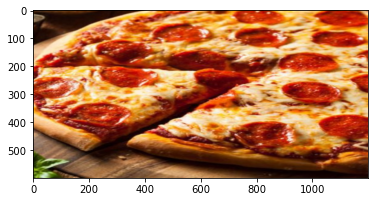

In [452]:
def show_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (1200, 600))
    plt.imshow(resized_image)
    plt.show()
    
show_image('/Users/pedrocerbino/Desktop/pizza.jpg')

## Color Identification

In [48]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [49]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [444]:
def get_colors(image,number_of_colors,show_chart=False):
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    global counts 
    counts = Counter(labels)
    counts = dict(sorted(counts.items(), key=lambda x: x[1]))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    global rgb_colors 
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    if (show_chart):
        plt.figure(figsize = (8, 6))
        _, _, autotexts =plt.pie(counts.values(), labels=hex_colors, colors=hex_colors,
                                 textprops={'size':13}, autopct='%1.1f%%',
                                 explode=list(np.ones(number_of_colors-2)/20) + [0.2,0.2],
                                 counterclock=False,shadow=True)
        plt.suptitle('Food Colors Percentage',size=20,y=1.06)

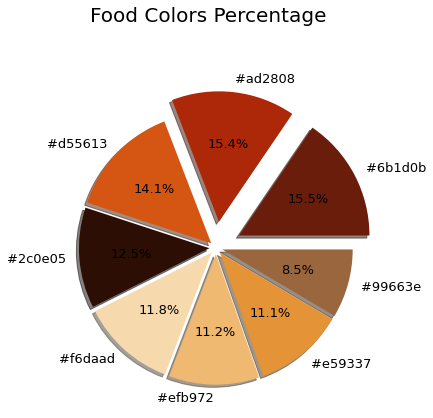

In [280]:
get_colors(get_image('/Users/pedrocerbino/Desktop/pizza.jpg'),8,True)

## Closest Primary Color Frequency

In [428]:
colours = ( (255, 255, 255, "white"),
            (181, 55, 55, "red"),
            (199, 234, 70, "green"),
            (102, 124, 38, "darkgreen"),
            (0, 0, 255, "darkblue"),
            (0, 255, 255, "lightblue"),
            (255, 0, 255, "pink"),
            (255, 121, 0, "orange"),
            (253, 208, 23, "yellow"),
            (0, 0, 0, "black"),
            (92, 50, 10, "brown") )

def nearest_colour(subjects, query):
    return min(subjects, key = lambda subject: sum((s - q)**2 for s, q in zip(subject, query)))

In [248]:
def get_closest_colors():
    colors = []
    for c in rgb_colors:
        colors.append(nearest_colour(colours, c)[-1])
        
    return colors

In [320]:
def get_closest_colors_frequency():
    dicti=pd.Series(index=(pd.Series(counts).divide(pd.Series(counts).sum()).round(3)*100).values,
       data=get_closest_colors())
    print(pd.Series(dicti.index.values,index=dicti).groupby(level=0).sum())
    
def return_closest_colors_frequency():
    dicti=pd.Series(index=(pd.Series(counts).divide(pd.Series(counts).sum()).round(3)*100).values,
        data=get_closest_colors())
    return pd.Series(dicti.index.values,index=dicti).groupby(level=0).sum()

## Weighted Scores

darkgreen: 100  # hortaliças ricas em nutrientes

green: 81  # saladas, hortaliças, verduras e legumes

black: 64  # feijão preto

brown: 49  # feijão mulato, carnes

white: 36  # arroz branco

yellow: 25  # batata frita, carboidratos calóricos

orange: 16  # cheddar, queijos gordurosos

red: 9 # linguiça, salsicha


In [404]:
def get_score():

    data  = pd.DataFrame(data=return_closest_colors_frequency().values,
                index=return_closest_colors_frequency().index,columns=['Percentual'])
    data.reset_index(inplace=True)
    data.rename(columns={'index':'Color'},inplace=True)

    for key, value in {'darkgreen':100,'green':81,'black':64,'brown':49,'white':36,'yellow':25,
                       'orange':16,'red':9}.items():
        data.loc[data.Color == key, 'Multiplicador'] = value

    data['Score'] = data['Percentual'] * data['Multiplicador']
    print(f"O Score Total é de: {np.sqrt(data['Score'].sum()*data['Multiplicador'].sum()):.2f}")

def return_score():
    
    data  = pd.DataFrame(data=return_closest_colors_frequency().values,
                index=return_closest_colors_frequency().index,columns=['Percentual'])
    data.reset_index(inplace=True)
    data.rename(columns={'index':'Color'},inplace=True)

    for key, value in {'darkgreen':100,'green':81,'black':64,'brown':49,'white':36,'yellow':25,
                       'orange':16,'red':9}.items():
        data.loc[data.Color == key, 'Multiplicador'] = value

    data['Score'] = data['Percentual'] * data['Multiplicador']
    
    return np.sqrt(data['Score'].sum()*data['Multiplicador'].sum())

In [401]:
get_score()

O Score Total é de: 1363.65


## Checking for all the Photos

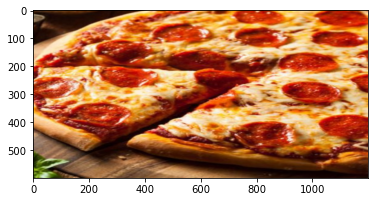

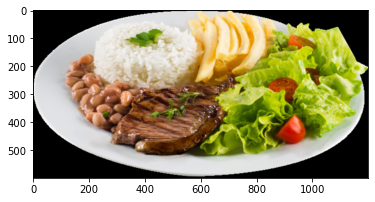

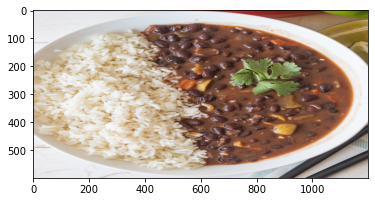

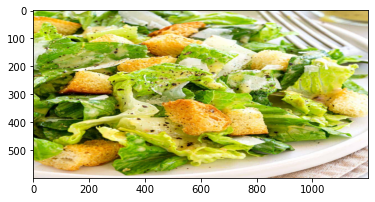

In [453]:
for i in ['pizza.jpg','balanced meal.png','rice and beans.jpg','salad.jpg']:
    show_image('/Users/pedrocerbino/Desktop/'+i)

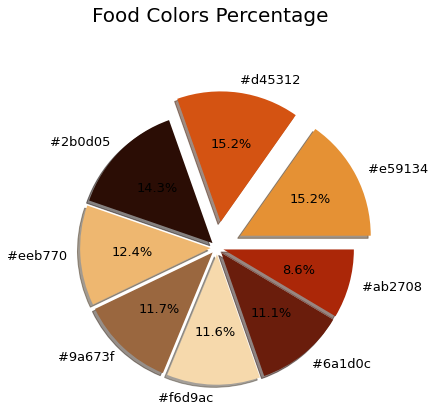

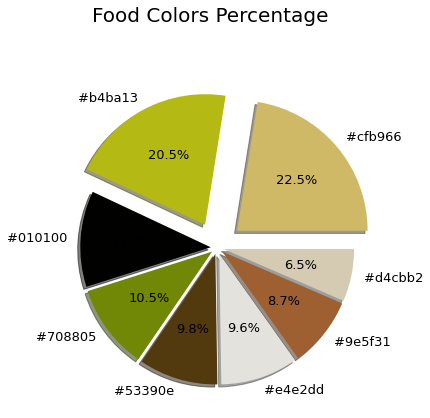

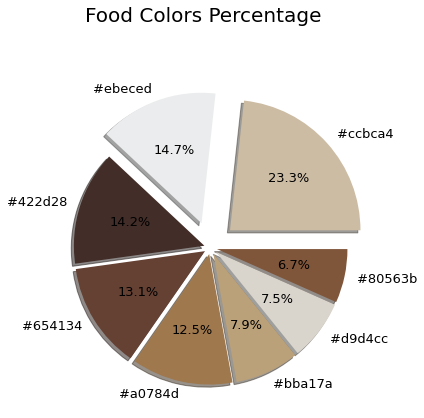

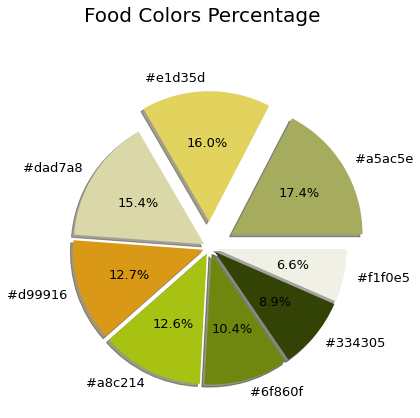

In [394]:
for i in ['pizza.jpg','balanced meal.png','rice and beans.jpg','salad.jpg']:
    get_colors(get_image('/Users/pedrocerbino/Desktop/'+i),8,True)

## Creating the Ranking

In [454]:
scores = {}
for i in ['pizza.jpg','balanced meal.png','rice and beans.jpg','salad.jpg']:
    print(i)
    get_colors(get_image('/Users/pedrocerbino/Desktop/'+i),8)
    get_closest_colors_frequency()
    get_score()
    scores[i] = return_score()
    print('\n')

pizza.jpg
black     12.5
brown     11.0
green     14.2
orange    11.5
red       42.2
white      8.5
dtype: float64
O Score Total é de: 925.50


balanced meal.png
black        11.8
brown        10.3
darkgreen    22.4
green        19.5
red          20.9
white        15.2
dtype: float64
O Score Total é de: 1403.99


rice and beans.jpg
brown        30.9
darkgreen    26.6
green        21.0
white        21.5
dtype: float64
O Score Total é de: 1329.91


salad.jpg
brown        15.3
darkgreen    16.1
green        49.4
orange       12.7
white         6.5
dtype: float64
O Score Total é de: 1384.60




In [456]:
d = pd.DataFrame(index=scores.keys(),data=scores.values(),columns=['Score']).sort_values('Score',
                                                                                ascending=False)
d.insert(0,'Ranking',range(1,len(d)+1))
d

,Ranking,Score
balanced meal.png,1,1403.988355
salad.jpg,2,1384.601242
rice and beans.jpg,3,1329.909997
pizza.jpg,4,925.497164
